# INSPECT and Clean TTS DATASET

This notebook is referenced in my [main](https://www.kaggle.com/code/maxbr0wn/tutorial-fine-tuning-xttsv2-english/) notebook on fine-tuning XTTS-v2 for text to speech task. It would be useful for training other TTS models as well.

This is largely cannibalised from a TTS team notebook [here](https://github.com/coqui-ai/TTS/blob/dev/notebooks/dataset_analysis/AnalyzeDataset.ipynb). There are several notebooks provided by coqui for looking at your dataset. This is the most (only?) important one for fine-tuning XTTS-v2.

Note that you might consider running through this notebook with the attached janeeyre dataset before loading in your own to get a feel for what a reasonably high-quality dataset looks like.

Note that it's not necessary to use an accelerator for this notebook.

In [1]:
!pip install git+https://github.com/coqui-ai/TTS

  Cloning https://github.com/coqui-ai/TTS to /tmp/pip-req-build-yb2qh7qk
  Running command git clone --filter=blob:none --quiet https://github.com/coqui-ai/TTS /tmp/pip-req-build-yb2qh7qk
  Resolved https://github.com/coqui-ai/TTS to commit dbf1a08a0d4e47fdad6172e433eeb34bc6b13b4e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 47.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 77.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import sys
import csv
import shutil
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.config.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.datasets.formatters import *
%matplotlib inline

### Load Dataset

I assume your dataset is in LJSpeech format. ([here](https://github.com/zuverschenken/XTTSv2Scripts) is my github repo showing how to create your LJSpeech style dataset from one or more .mp3 files.)

In [3]:
training_dir = '/kaggle/input/janeeyre'
NUM_PROC = 4
DATASET_CONFIG = BaseDatasetConfig(
    formatter="ljspeech", meta_file_train="metadata.csv", path=training_dir
)

In [4]:
def formatter(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    txt_file = os.path.join(root_path, meta_file)
    items = []
    speaker_name = "myspeaker"
    with open(txt_file, "r", encoding="utf-8-sig") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0] + ".wav")            
            text = cols[1]
            items.append({"text": text, "audio_file": wav_file, "speaker_name": speaker_name, "root_path": root_path})
    return items

In [5]:
train_samples, eval_samples = load_tts_samples(DATASET_CONFIG, eval_split=True, formatter=formatter)
if eval_samples is not None:
    items = train_samples + eval_samples
else:
    items = train_samples

 | > Found 10055 files in /kaggle/input/janeeyre


In [6]:
print(" > Number of audio files: {}".format(len(items)))
items[0]

 > Number of audio files: 10055


{'text': 'I think not, sir.',
 'audio_file': '/kaggle/input/janeeyre/wavs/jane_eyre_03_f000138.wav',
 'speaker_name': 'myspeaker',
 'root_path': '/kaggle/input/janeeyre',
 'language': '',
 'audio_unique_name': '#wavs/jane_eyre_03_f000138'}

In [7]:
# print out names of missing wavs
wav_files = []
for item in items:
    wav_file = item["audio_file"].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [8]:
# print out names of duplicate wavs
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


### Compute Audio/Text Lengths

In [9]:

def load_item(item):
    text = item["text"].strip()
    file_name = item["audio_file"].strip()
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(NUM_PROC) as p: 
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 10055/10055 [00:25<00:00, 397.26it/s]


In [10]:
# look at breadth of vocabulary
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 10055/10055 [00:00<00:00, 146100.22it/s]

 > Number of words: 23133


In [11]:
#length of text, duration of audio in seconds and compare
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
lengths = []
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    lengths.append(text_len)
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]


100%|██████████| 10055/10055 [00:00<00:00, 808204.49it/s]


In [12]:
#for each bucket of char lengths, find averages for that length vs duration of audio
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)



In [13]:
#per char duration
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
    
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.07636650258489149
0.03176999786686174


### Visualise Dataset

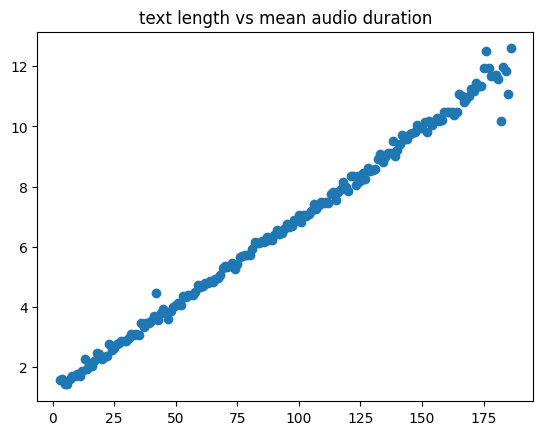

In [14]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

Note that "text length" is amount of chars. Audio duration should basically be a linear function of text length.

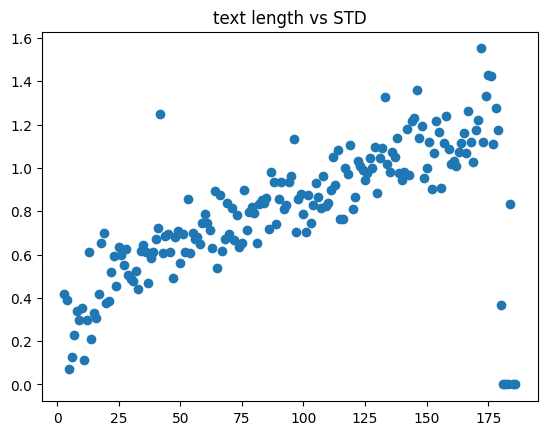

In [15]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

This is showing us, for each set of data items with a particular char length, what is one standard deviation in audio duration for that set.

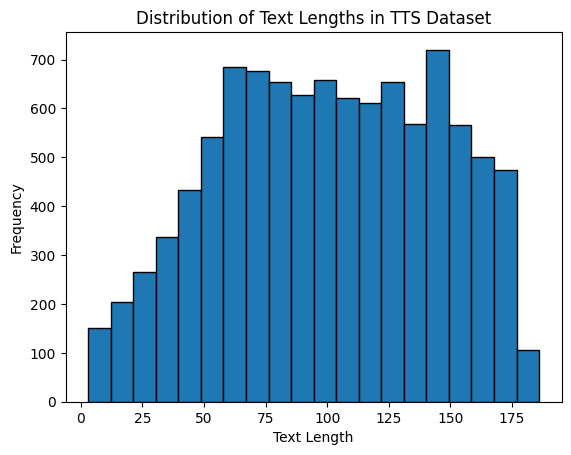

In [16]:
plt.hist(lengths, bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in TTS Dataset')
plt.show()

The TTS docs recommends a 'Gaussian-like' distribution of clip lengths. A fairly uniform distribution should be fine too. I think the most important thing is to have examples across a range of different lengths. From my experience, the model does not generalise well across different sequence lengths (i.e., if you fine-tune with no short 1.5s clips and then try to create such a short clip at inference time, then it will probably struggle).

### Clean the Dataset

Now we will apply some filters to remove items from our dataset that are likely to be problematic

In [17]:
cleaned_data=[]
len(data), len(cleaned_data)

(10055, 0)

In [18]:
#first find our per char duration mean/sd
durs_per_char = []
for each in data:
    durs_per_char.append(each[-1]/each[2])
durs_mean = np.mean(durs_per_char)
durs_sd = np.std(durs_per_char)

durs_mean, durs_sd

(0.07636650258489149, 0.03176999786686174)

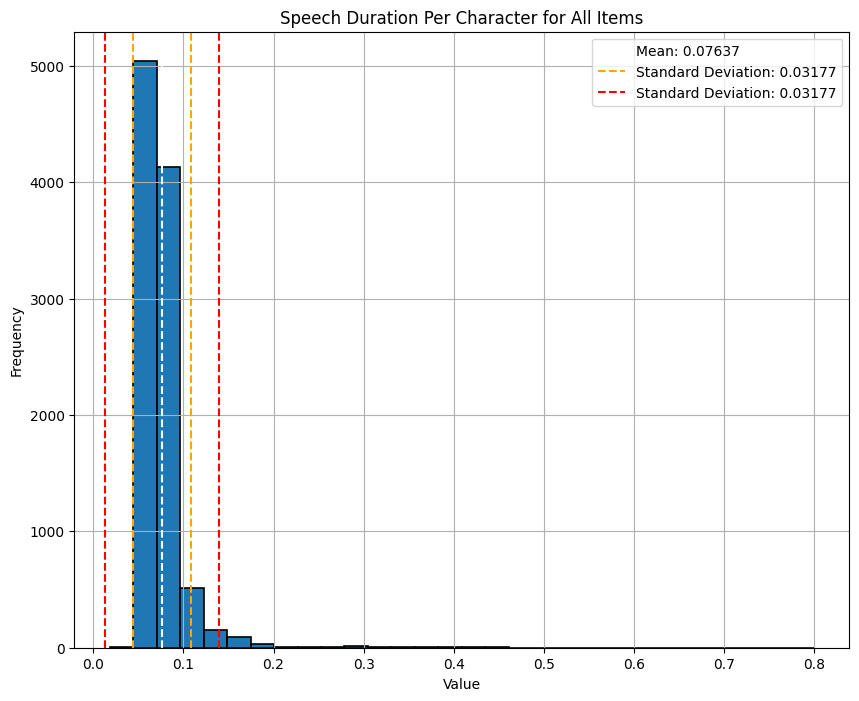

In [19]:
points = durs_per_char
mean = durs_mean
std_dev = durs_sd

plt.figure(figsize=(10, 8)) 
plt.hist(points, bins=30, edgecolor='black', linewidth=1.2)

# Add vertical lines for mean and standard deviation
plt.axvline(mean, color='white', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean:.5f}')
plt.axvline(mean + std_dev, color='orange', linestyle='dashed', linewidth=1.5, label=f'Standard Deviation: {std_dev:.5f}')
plt.axvline(mean - std_dev, color='orange', linestyle='dashed', linewidth=1.5)
plt.axvline(mean + 2*std_dev, color='red', linestyle='dashed', linewidth=1.5, label=f'Standard Deviation: {std_dev:.5f}')
plt.axvline(mean - 2*std_dev, color='red', linestyle='dashed', linewidth=1.5)

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Speech Duration Per Character for All Items')

# Show plot
plt.grid(True)
plt.show()

We have found the mean duration per character of text and the above histogram shows how our dataset is distributed around that mean.

Next we will filter out items with too short duration, items with too long duration, and items with too much variance

In [21]:
minimum_duration = 0.7
maximum_duration = 13.0
maximum_sds = 2.5

In [22]:
#TODO: add separate filter for removing items whose char length is > 250

cleaned_data = []

shorties = []
longies = []
misfits = []
for item in data:
    item_perchar_dur = item[-1]/item[2]
    difference = abs(item_perchar_dur-durs_mean)
    item_zscore = difference / durs_sd
    item = item + (item_zscore,) #add the zscore to the data item so we can sort by it later
    if item[-2] < minimum_duration:
        shorties.append(item)
    elif item[-2] > maximum_duration:
        longies.append(item)
    elif item_zscore > maximum_sds:
        misfits.append(item)
    else:
        cleaned_data.append(item)

excluded = shorties + longies + misfits

        
print(f"found {len(shorties)} short items and {len(longies)} long items and {len(misfits)} items whose length conformed but whose per-char duration exceeded {maximum_sds} standard deviations from the mean. Excluding {len(shorties)+len(longies)+len(misfits)} items")      

found 0 short items and 122 long items and 175 items whose length conformed but whose per-char duration exceeded 2.5 standard deviations from the mean. Excluding 297 items


Look at the items we are deeming too short to see if it looks sensible to exclude them

In [23]:
ranked_shorts = sorted(shorties, key=lambda x: x[-2])
if len(ranked_shorts) > 0:
    print(f"Duration of shortest item excluded for being too short: {ranked_shorts[0][-2]} Text from shortest item excluded for being too short: {ranked_shorts[0][1]}")
    print(ranked_shorts[0])
    print(f"Duration of longest item excluded for being too short: {ranked_shorts[-1][-2]} Text from shortest item excluded for being too short: {ranked_shorts[-1][1]}")
    print(ranked_shorts[-1])


Likewise for the items with high variance (you might want to play around with the maximum_sds value above to find the right level of exclusion)

(If you are following along in the janeeyre dataset, this actually picks up some items from the dataset that were mislabelled)

In [24]:
ranked_misfits = sorted(misfits, key=lambda x: x[-1])[::-1]
if len(ranked_misfits) > 0:
    print(f"Duration of worst item excluded for having too much variance: {ranked_misfits[0][-2]} and its text: {ranked_misfits[0][1]}")
    print(ranked_misfits[0])
    print(f"Duration of best item excluded for having too much variance: {ranked_misfits[-1][-2]} and its text: {ranked_misfits[-1][1]}")
    print(ranked_misfits[-1])


Duration of worst item excluded for having too much variance: 2.3998125 and its text: No.
('/kaggle/input/janeeyre/wavs/jane_eyre_33_f000056.wav', 'No.', 3, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 2.3998125, 22.775292603020347)
Duration of best item excluded for having too much variance: 2.8048125 and its text: End of chapter 20.
('/kaggle/input/janeeyre/wavs/jane_eyre_20_f000332.wav', 'End of chapter 20.', 18, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 2.8048125, 2.5009889649584647)


The following code is copy pasted from above--we are recomputing on our cleaned dataset to inspect it and compare

In [25]:

text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
lengths = []
for item in tqdm(cleaned_data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    lengths.append(text_len)
    audio_len = item[-2]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 9758/9758 [00:00<00:00, 887366.79it/s]


In [26]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

In [27]:
sec_per_chars = []
for item in cleaned_data:
    text = item[1]
    dur = item[-2]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(cleaned_data)
# print(sec_per_char)

In [28]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.07319660560989946
0.015154627530377428


We should see less outliers in the visualisations below and a tighter distribution of audio duration per char

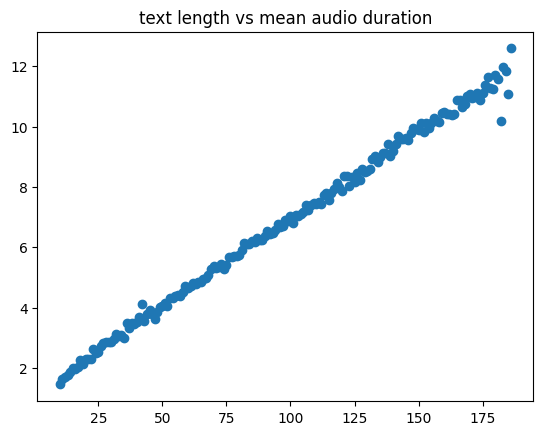

In [29]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

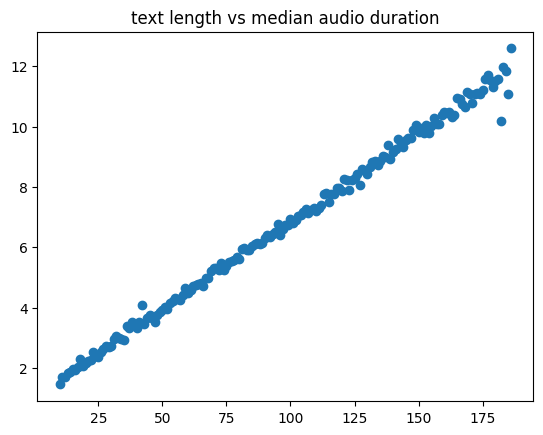

In [30]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

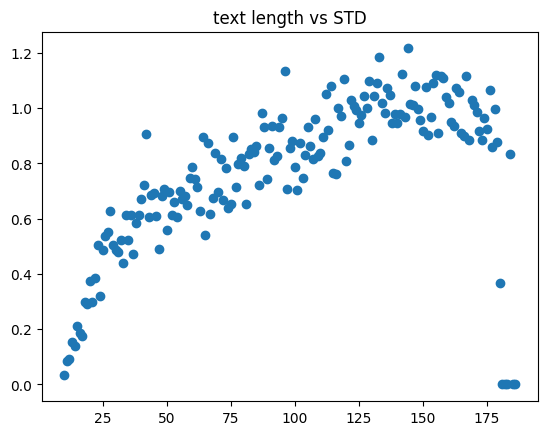

In [31]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

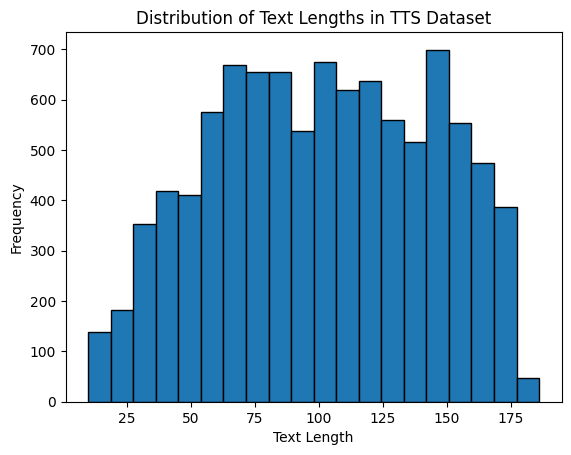

In [32]:
plt.hist(lengths, bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in TTS Dataset')
plt.show()

In [33]:
#after cleaning distribution
#first find our per char duration mean/sd
durs_per_char = []
for each in cleaned_data:
    durs_per_char.append(each[-2]/each[2])
durs_mean = np.mean(durs_per_char)
durs_sd = np.std(durs_per_char)

durs_mean, durs_sd

(0.07319660560989946, 0.015154627530377428)

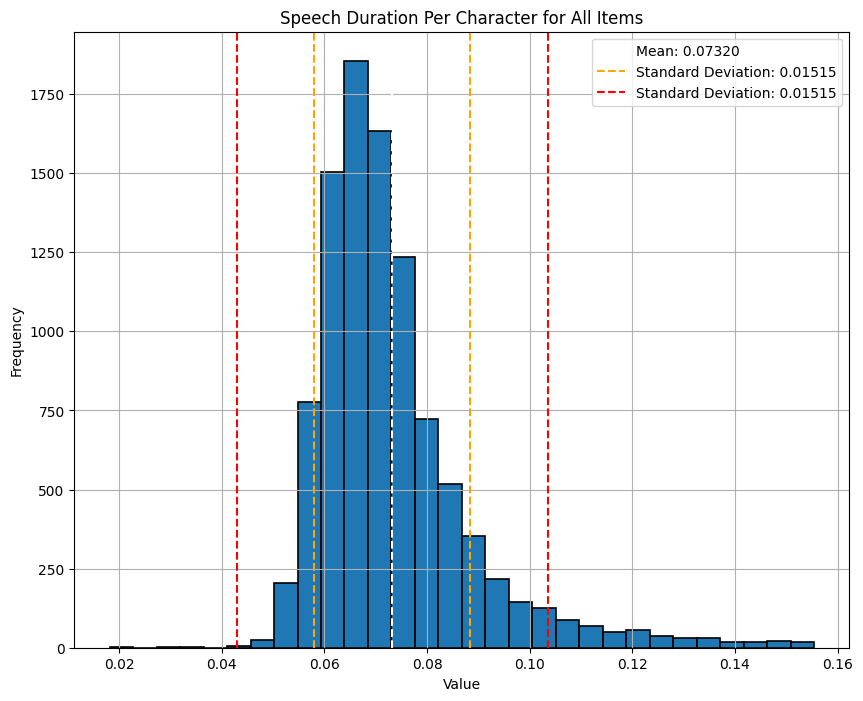

In [34]:
points = durs_per_char
mean = durs_mean
std_dev = durs_sd

plt.figure(figsize=(10, 8)) 
plt.hist(points, bins=30, edgecolor='black', linewidth=1.2)

# Add vertical lines for mean and standard deviation
plt.axvline(mean, color='white', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean:.5f}')
plt.axvline(mean + std_dev, color='orange', linestyle='dashed', linewidth=1.5, label=f'Standard Deviation: {std_dev:.5f}')
plt.axvline(mean - std_dev, color='orange', linestyle='dashed', linewidth=1.5)
plt.axvline(mean + 2*std_dev, color='red', linestyle='dashed', linewidth=1.5, label=f'Standard Deviation: {std_dev:.5f}')
plt.axvline(mean - 2*std_dev, color='red', linestyle='dashed', linewidth=1.5)

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Speech Duration Per Character for All Items')

# Show plot
plt.grid(True)
plt.show()

### Visualise Cull

Check how much content we are proposing to remove from our dataset. I don't know how much data is 'enough' to train on. In my experience, 2 hours is plenty of audio duration (I trained a model on 10 hours of audio and a 2 hour subset of that data and I couldn't notice much difference between the two). The more high quality content, the better.

If you are having to cut a large amount of data at this stage, then your dataset probably isn't being created correctly to begin with. [here](https://github.com/zuverschenken/XTTSv2Scripts) is my repo showing how to create a dataset.

In [35]:
len(excluded)

297

In [36]:
len(data), len(cleaned_data), len(cleaned_data)/len(data)

(10055, 9758, 0.9704624564893088)

In [37]:
remaining_length = sum([each[-2] for each in cleaned_data])
excluded_length = sum([each[-2] for each in excluded])
remaining_length, excluded_length

(68506.8988750001, 2084.726624999999)

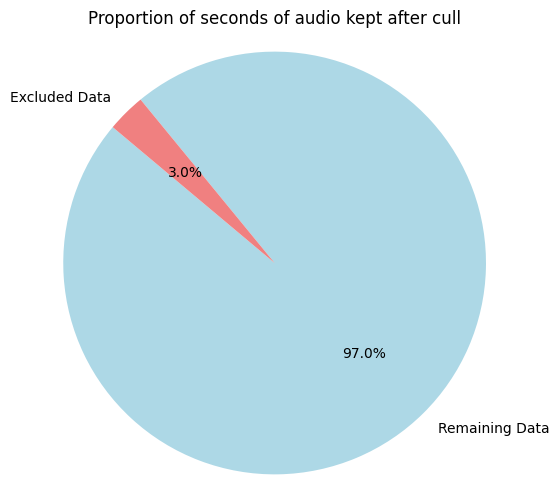

In [38]:

# Data for the pie chart (proportions)
sizes = [remaining_length, excluded_length]  # Example proportions, summing up to 100%

# Labels for each portion
labels = ['Remaining Data', 'Excluded Data']

# Colors for each portion
colors = ['lightblue', 'lightcoral']  # Adjusted color for 'lightred'

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of seconds of audio kept after cull')
plt.show()

In [39]:
def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    remaining_seconds = seconds % 60
    return hours, minutes, remaining_seconds

hours, minutes, remaining_seconds = seconds_to_hms(remaining_length)
print(f"Remaining length: {hours} hours, {minutes} minutes, and {remaining_seconds} seconds.")

Remaining length: 19.0 hours, 1.0 minutes, and 46.898875000100816 seconds.


In [40]:
hours, minutes, remaining_seconds = seconds_to_hms(excluded_length)
print(f"Excluded length: {hours} hours, {minutes} minutes, and {remaining_seconds} seconds.")

Excluded length: 0.0 hours, 34.0 minutes, and 44.726624999998876 seconds.


### Check Parameter for Fine-tune

If you are using this data with XTTS-v2, you should use the maximum audio length from your dataset as max_wav_length and ensure the length of the reference audio you want to use is within the min-max range.

In [41]:
speaker_reference = '/kaggle/input/janeeyre/wavs/jane_eyre_01_f000015.wav'
audio, sr = librosa.load(os.path.join(training_dir, 'wavs', speaker_reference), sr=None)


In [42]:
rawLength = [x[-2] for x in cleaned_data]

print(f"seconds: {max(rawLength)}")
print(f"maximum audio file length: {max(rawLength)*sr}")

seconds: 12.9798125
maximum audio file length: 207677.0


In [43]:
print(f"speaker reference file length: {len(audio)}")


speaker reference file length: 143677


### Delete Unwanted Files

Finally we copy across the files we want to keep to /kaggle/working 

In [44]:
out_dir = '/kaggle/working/'

In [45]:
excluded_files = set([each[0].split('/')[-1].split('.')[0] for each in excluded])

In [46]:
#grab the rows we will keep
dropped = 0
sanitised_rows = []
with open(os.path.join(training_dir, 'metadata.csv'), 'r') as file:
    csv_reader = csv.reader(file, delimiter='|')
    for row in csv_reader:
        if row[0] not in excluded_files:
            sanitised_rows.append(row)
        else:
            dropped += 1

#sanity check
assert dropped == len(excluded_files)

In [47]:
#create a new csv
with open(os.path.join(out_dir, 'metadata.csv'), 'w', encoding='utf-8') as file:
    csv_writer = csv.writer(file, delimiter = '|')
    for row in sanitised_rows:
        csv_writer.writerow(row)

**Note: copying all wavs to working dir. This might take some time**

In [48]:
wavs_dir = os.path.join(out_dir, 'wavs')
os.makedirs(wavs_dir, exist_ok=True)

files = os.listdir(os.path.join(training_dir, 'wavs'))

for file in files:
    source_file = os.path.join(training_dir,'wavs', file)
    destination_file = os.path.join(wavs_dir, file)
    shutil.copy2(source_file, destination_file)


Delete the unwanted wavs

In [ ]:
#delete wavs
deleted_files = 0
for file_name in excluded_files:
    file_path = os.path.join(wavs_dir, file_name + '.wav')
    try:
        os.remove(file_path)
        deleted_files += 1
    except OSError as e:
        print(f'Error deleting file {file_path}: {e}')

#sanity check
assert deleted_files == dropped
print(f'deleted {deleted_files} wavs')

Create a tarball that you can download. Again, this might take a little while.

In [ ]:
!tar -czvf culled_dataset.tar.gz /kaggle/working/*